In [1]:
from BOVW import BOVW
from DeepModel import DeepModel
import os
import numpy as np
from mtcnn import MTCNN
import tensorflow as tf
from tensorflow import keras
from pathlib import Path
import skimage
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
import pickle

In [2]:
# Siamese model paths
classifier_path = "./CNN_training/Classifier/svm_final_nu03.sav"
siamese_embeddings = "./CNN_training/final_siamese_embedding_model"
siamese_savory = "./CNN_training/Features/feature_savory.pkl"
siamese_unsavory = "./CNN_training/Features/feature_unsavory.pkl"
image_train_paths = "./CNN_training/Features/path_final.pkl"

# BOVW paths
bovw_path = './BOVW/bovw/bovw.pkl'
bovw_savory = './BOVW/bovw/feature_savory.pkl'
bovw_unsavory = './BOVW/bovw/feature_unsavory.pkl'
train_image_path = './BOVW/bovw/train_paths.pkl'

#Images_path
im_path = './Test_my_photo/test_pre_after/'

# Preprocessing

In [3]:
detector = MTCNN()

In [4]:
def preprocess_all(im):
    ycbcr = skimage.color.rgb2ycbcr(im)
    ycbcr = ycbcr/255
    y = ycbcr[:,:,0]
    value = np.sum(y<0.5) / np.sum(y>0.5)
    if value > 5 or value == "inf":
        y = skimage.exposure.adjust_gamma(y, 0.7)
    elif value < 0.2:
        y = skimage.exposure.adjust_gamma(y, 1.3)
    ycbcr[:,:,0] = y
    final = skimage.color.ycbcr2rgb(ycbcr*255)
    final = skimage.filters.unsharp_mask(final, radius=2, amount=1)
    final = np.clip(final, 0,1)*255
    return final


In [5]:
def process_crop(im):
    im = (im - np.min(im)) / (np.max(im) - np.min(im))
    ycbcr = skimage.color.rgb2ycbcr(im)
    ycbcr = ycbcr/255
    y = ycbcr[:,:,0]
    sharp= False
    value = np.sum(y<0.5) / np.sum(y>0.5)
    if value > 5 or value == "inf" or value < 0.2:
        sharp = True
    while True:
        value = np.sum(y<0.5) / np.sum(y>0.5)
        if value > 5 or value == "inf":
            y = skimage.exposure.adjust_gamma(y, 0.8)
        elif value < 0.2:
            print(value)
            y = skimage.exposure.adjust_gamma(y, 1.2)
        else:
            break
    ycbcr[:,:,0] = y
    final = skimage.color.ycbcr2rgb(ycbcr*255)
    final = np.clip(final, 0,1)
    # enhanced image = original + amount * (original - blurred)
    if sharp:
        final = skimage.filters.unsharp_mask(final, radius=2, amount=1)
    else:
        final = skimage.filters.unsharp_mask(final, radius=1, amount=0.5)

    return final

In [6]:
def try_rotate(img):
    faces = []
    im = []
    for i in range(0, 360, 90):
        im = skimage.transform.rotate(img, i, resize=True)*255
        im = np.clip(im, 0,255)
        faces = detector.detect_faces(im)
        if len(faces)>0:
            break
    return faces, im, i

In [7]:
def find_face_and_preprocess(path):
    final_imgs = []
    im = imread(path)
    crops = []
    faces = detector.detect_faces(im)
    if len(faces)==0:
        im = preprocess_all(im)
        faces = detector.detect_faces(im)
        if len(faces)==0:
            faces, im, _ = try_rotate(im)
            print(len(faces))
            if len(faces) == 0:
                return None
    for face in faces:
        [X,Y,W,H] = face['box']
        crop = im[Y:Y+H, X:X+W]
        face = detector.detect_faces(crop)
        print(len(face))
        if len(face) == 0:
            face, crop, rotation = try_rotate(crop)
            im = skimage.transform.rotate(im, rotation, resize=True)
            face = detector.detect_faces(im*255)
            [X,Y,W,H] = face[0]['box']
        print(len(face))
        if len(face) == 1:
            base = len(im[:,1,1])
            h = len(im[1,:,1])
            bord_x = 30
            bord_y = 70
            crop = im[Y:Y+H, X:X+W]
            if (Y-bord_y > 0) and (Y+H+bord_y < h) and (X-bord_x > 0) and (X+W+bord_x < base):
                crops += [im[Y-bord_y:Y+H+bord_y, X-bord_x:X+W+bord_x]]
            else:
                crops += [im[Y:Y+H, X:X+W]]
    if len(crops) == 0:
        print("no faces")
        return None
    else:
        for crop in crops:
            final_crop = process_crop(crop)
            final_imgs += [final_crop]
    return final_imgs

In [14]:
images_path = list(Path(im_path).rglob(f"*.jpg"))
name = [path.parts[-1] for path in images_path]
new_path = './Test_my_photo/test_pre_after_processed/'

In [17]:
%%capture
for i in range(len(images_path)):
    img = find_face_and_preprocess(images_path[i])
    path_save = new_path + str(name[i])
    imsave(path_save, img[0])

# Models

In [18]:
new_images = list(Path(new_path).rglob(f"*.jpg"))

In [19]:
model = DeepModel(
        classifier_path, 
        siamese_embeddings, 
        image_train_paths, 
        siamese_savory,
        siamese_unsavory, 
        (200, 200)
        )

Model loaded from CNN_training\final_siamese_embedding_model
KDTree computed in: 0.17179210000000467


In [20]:
%%capture
predict_siamese = []
predict_bovw = []
for path in new_images:
    predict_siamese.append(model.predict(path))
    result, _, _, _ = BOVW.cbir(bovw_path, path, bovw_savory, bovw_unsavory, train_image_path)
    predict_bovw.append(result)

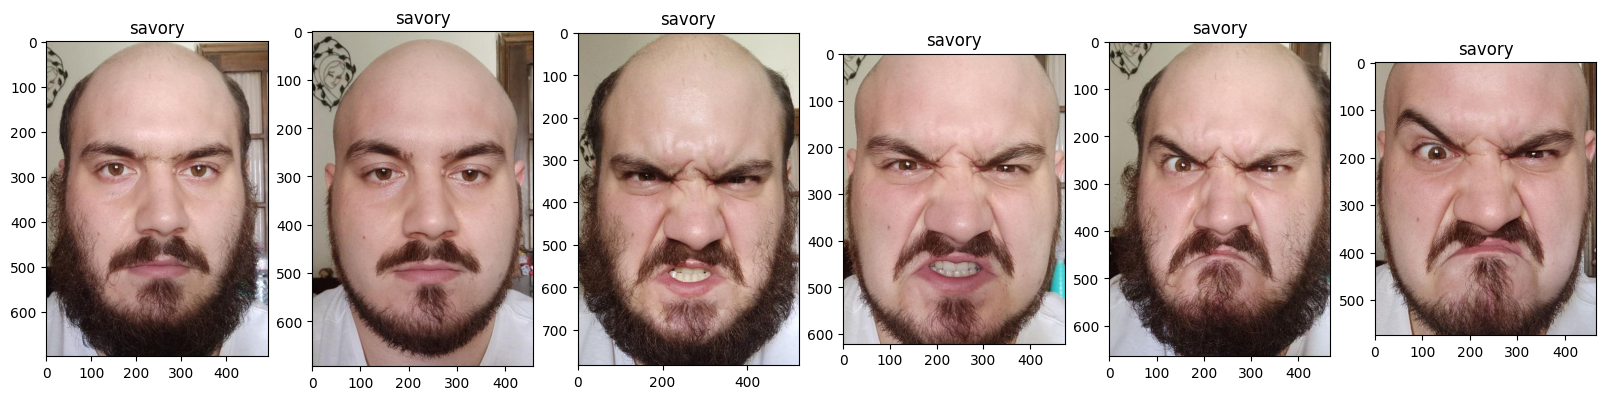

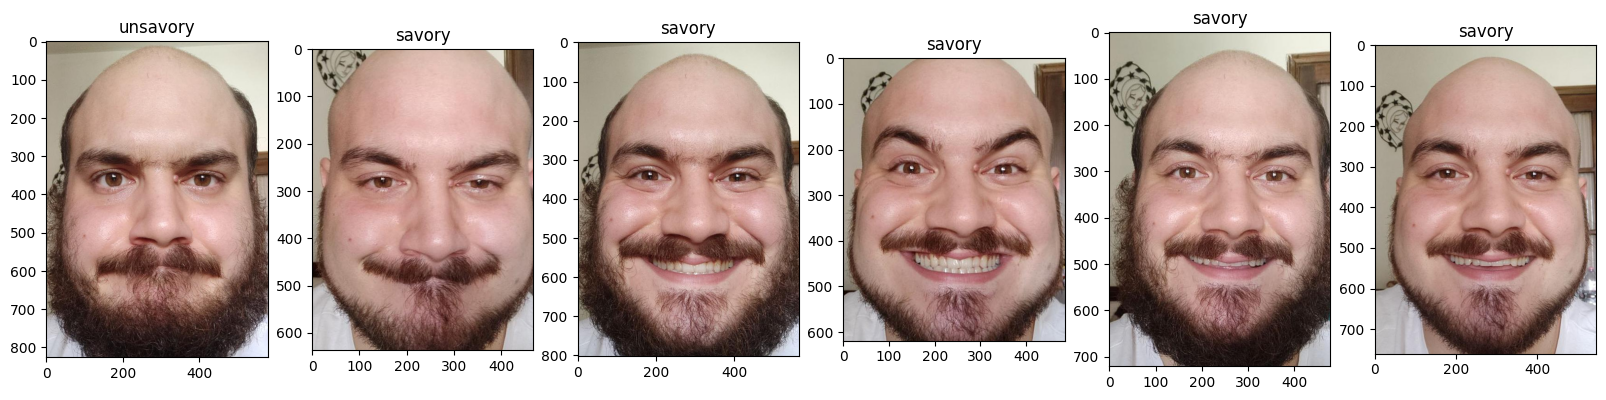

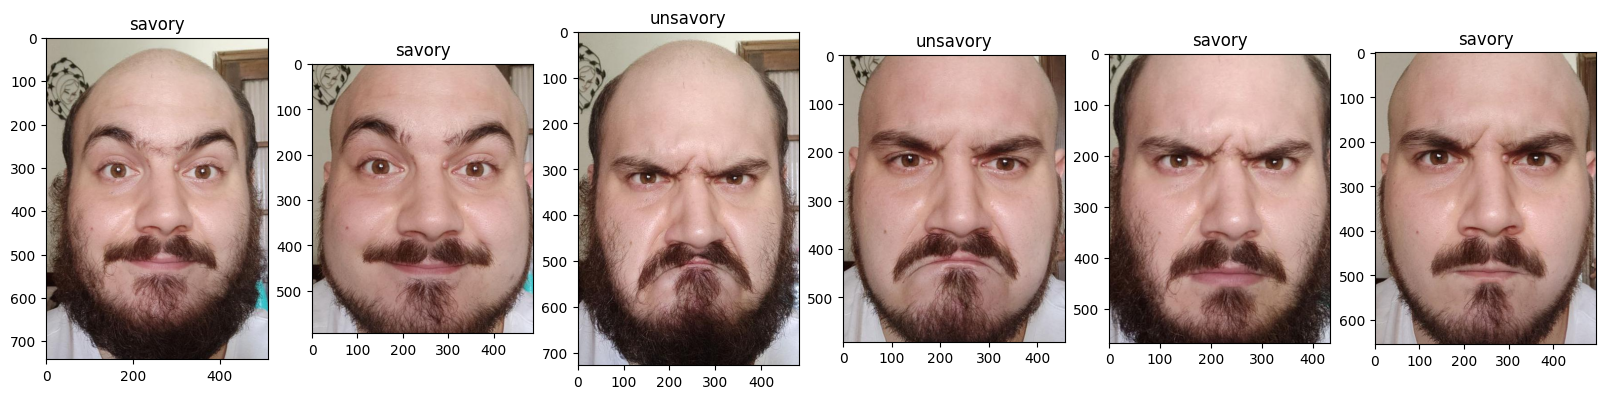

In [21]:
#BOVW
for i in range(0,len(new_images),6):
    im1 = plt.imread(new_images[i])
    im2 = plt.imread(new_images[i+1])
    im3 = plt.imread(new_images[i+2])
    im4 = plt.imread(new_images[i+3])
    im5 = plt.imread(new_images[i+4])
    im6 = plt.imread(new_images[i+5])
    plt.figure(figsize=(20,10))
    plt.subplot(1,6,1)
    plt.title(predict_bovw[i][0])
    plt.imshow(im1)
    plt.subplot(1,6,2)
    plt.title(predict_bovw[i+1][0])
    plt.imshow(im2)
    plt.subplot(1,6,3)
    plt.title(predict_bovw[i+2][0])
    plt.imshow(im3)
    plt.subplot(1,6,4)
    plt.title(predict_bovw[i+3][0])
    plt.imshow(im4)
    plt.subplot(1,6,5)
    plt.title(predict_bovw[i+4][0])
    plt.imshow(im5)
    plt.subplot(1,6,6)
    plt.title(predict_siamese[i+5][0])
    plt.imshow(im6)

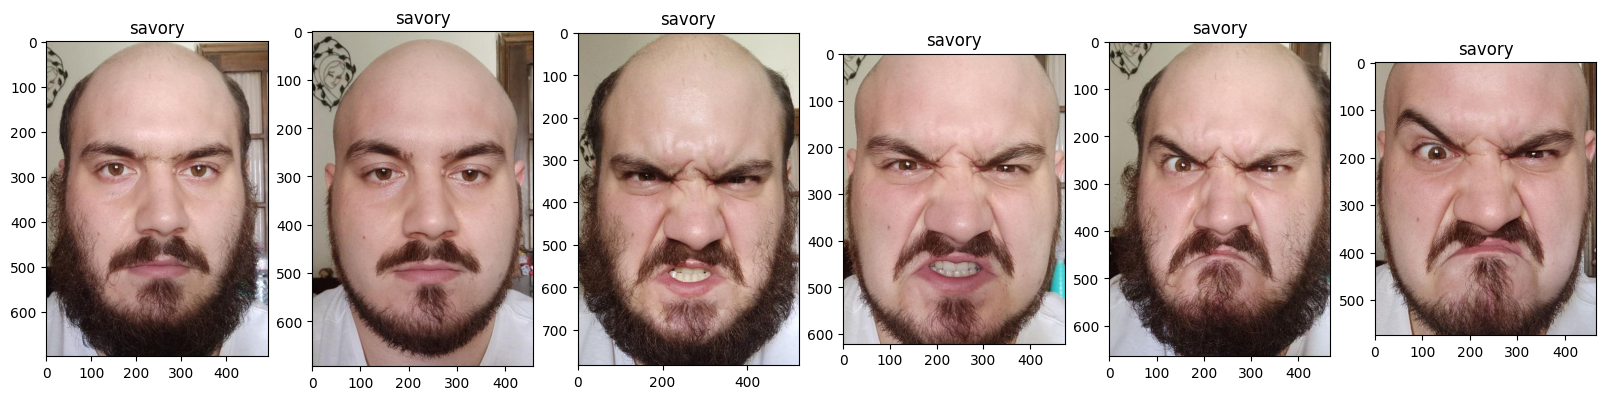

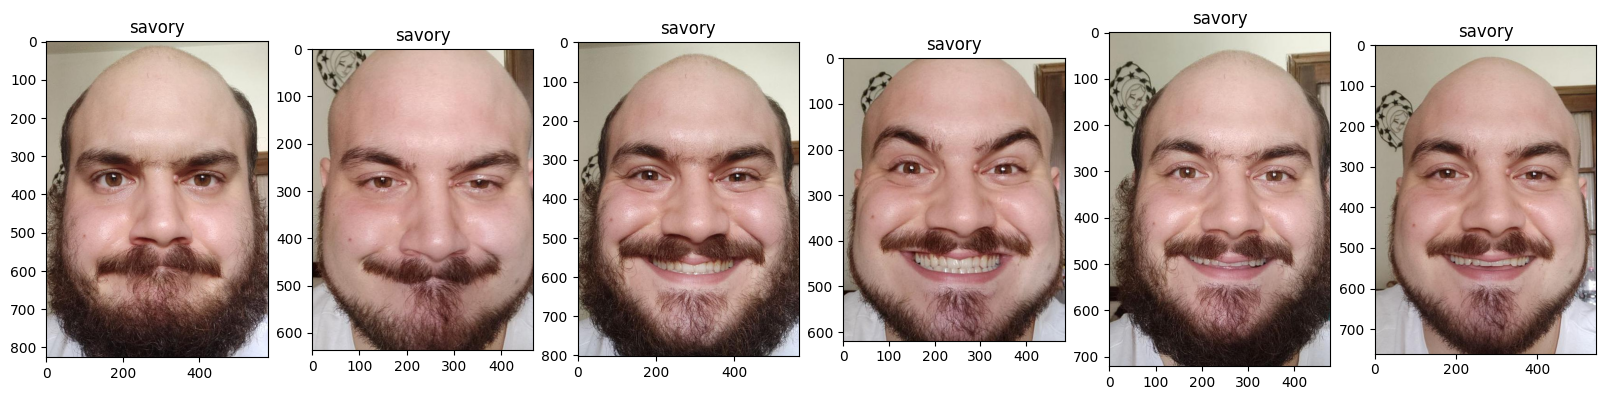

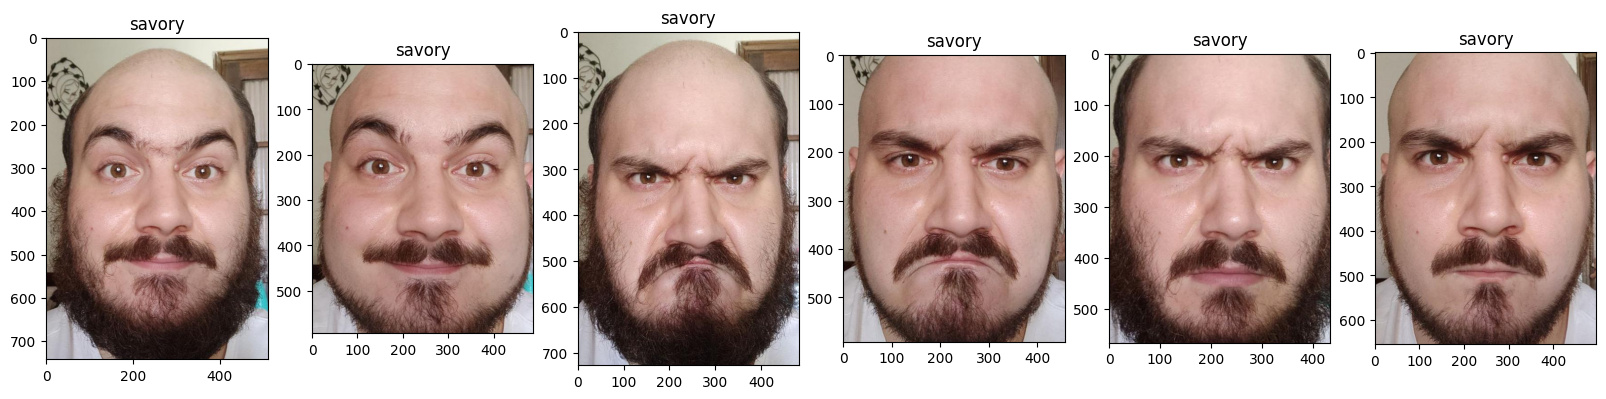

In [22]:
#SIAMESE
for i in range(0,len(new_images),6):
    im1 = plt.imread(new_images[i])
    im2 = plt.imread(new_images[i+1])
    im3 = plt.imread(new_images[i+2])
    im4 = plt.imread(new_images[i+3])
    im5 = plt.imread(new_images[i+4])
    im6 = plt.imread(new_images[i+5])
    plt.figure(figsize=(20,10))
    plt.subplot(1,6,1)
    plt.title(predict_siamese[i][0])
    plt.imshow(im1)
    plt.subplot(1,6,2)
    plt.title(predict_siamese[i+1][0])
    plt.imshow(im2)
    plt.subplot(1,6,3)
    plt.title(predict_siamese[i+2][0])
    plt.imshow(im3)
    plt.subplot(1,6,4)
    plt.title(predict_siamese[i+3][0])
    plt.imshow(im4)
    plt.subplot(1,6,5)
    plt.title(predict_siamese[i+4][0])
    plt.imshow(im5)
    plt.subplot(1,6,6)
    plt.title(predict_siamese[i+5][0])
    plt.imshow(im6)